In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
from collections import defaultdict
import crocoddyl 
import numpy as np
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
import numpy as np
import numdifftools as nd
import matplotlib.pyplot as plt
from jacobian import JacobianReg
import time
import math
from tqdm import tqdm
%matplotlib inline

In [22]:
def points(numPoints = 100):
    r = 2.
    points = []
    for index in range(numPoints):
        points.append([r*math.cos((index*2*math.pi)/numPoints),
                       r*math.sin((index*2*math.pi)/numPoints),
                       0])
        
    return np.array(points)  


def _data(size:int = 1000, theta:float = 0.):
    """
    Returns xtrain, ytrain.
    Returns data in the form of x --> L(x)
    
    """

    _xtrain = []
    _ytrain = []
    model = crocoddyl.ActionModelUnicycle()
    T = 30
    model.costWeights = np.matrix([1,1]).T
    
    for _ in range(size):
        # Generate random starting configuration
        xyz = [np.random.uniform(-2.1, 2.1), 
               np.random.uniform(-2.1, 2.1),
               theta]
        
        problem = crocoddyl.ShootingProblem(m2a(xyz).T, [ model ] * T, model)
        ddp = crocoddyl.SolverDDP(problem)
        ddp.solve()
        
        # Calculate the squared error
        cost = [ddp.cost]
        
        _xtrain.append(xyz)
        _ytrain.append(cost)
        
    xtrain = torch.tensor(_xtrain, dtype = torch.float32)
    ytrain = torch.tensor(_ytrain, dtype = torch.float32)
        
    return xtrain, ytrain
    
    
def squaredError(x):
    """
    Squared Error is calculated with respected to [0, 0, 0]

    @params:
        1:  x : Matrix or List
        
    @returns: Sum of squared error    
       
    """

    return m2a(x)**2 if m2a(x).size == 1 else sum(m2a(x)**2)


    
def _jacobian(net, x, noutputs):
    """
    @params:
        1: net      = Neural net to be differentiated
        2: x        = Input tensor to the neural net.
        3: noutputs = Size of the output of the neural net. 
                      Needed to define the size of the jacobian tensor
        
    @returns: d(N(x)) / d(x)
    
    """
    
    x = x.squeeze()
    n = x.size()[0]
    x = x.repeat(noutputs, 1)
    x.requires_grad_(True)
    y = net(x)
    y.backward(torch.eye(noutputs))
    return x.grad.data


class FeedForwardNet(nn.Module):
    def __init__(self, 
                 input_features,
                 output_features,
                n_hidden_units = 64):
        
        super(FeedForwardNet, self).__init__()
        
        # Structure
        self.fc1 = nn.Linear(input_features, n_hidden_units)
        self.fc2 = nn.Linear(n_hidden_units, n_hidden_units)
        self.fc3 = nn.Linear(n_hidden_units, output_features)
        
        # Initialization protocol
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        
      
        self.device = torch.device('cpu')
        self.to(self.device)

    def forward(self, x):
        
        x1 = F.relu(self.fc1(x)) 
        x2 = F.relu(self.fc2(x1)) 
        x3 = self.fc3(x2) 
        return x3
    
    
    
def a2m(a):
    return np.matrix(a).T


def m2a(m):
    return np.array(m).squeeze()


def jacobian(y, x, create_graph=False):                                                               
    jac = []                                                                                          
    flat_y = y.reshape(-1)                                                                            
    grad_y = torch.zeros_like(flat_y)                                                                 
    for i in range(len(flat_y)):                                                                      
        grad_y[i] = 1.                                                                                
        grad_x, = torch.autograd.grad(flat_y, x, grad_y, retain_graph=True, create_graph=create_graph)
        jac.append(grad_x.reshape(x.shape))                                                           
        grad_y[i] = 0.                                                                                
    return torch.stack(jac).reshape(y.shape + x.shape)                                                
                                                                                                      
def hessian(y, x):                                                                                    
    return jacobian(jacobian(y, x, create_graph=True), x)

class UnicycleTerminal(crocoddyl.ActionModelAbstract):
    def __init__(self, net):
        crocoddyl.ActionModelAbstract.__init__(self, crocoddyl.StateVector(3), 2, 5)
        self.net = net
    def calc(self, data, x, u=None):
        x = torch.as_tensor(m2a(x), dtype = torch.float32).resize_(1, 3)
        with torch.no_grad():
            data.cost = self.net(x).item()

    def calcDiff(self, data, x, u=None):
        if u is None:
            u = self.unone
        x0 = torch.as_tensor(m2a(x), dtype = torch.float32).resize_(1, 3)
        x0.requires_grad_(True)
        j = jacobian(self.net(x0), x0)
        h = hessian(self.net(x0), x0)
        data.Lx = a2m(j.detach().numpy())
        data.Lxx = a2m(h.detach().numpy())
        
        
        
        # Calculate MSE for test
def validation(net):
    """
    Returns the validation score(MSE) for regression
    
    """
    
    # Generate the test data... 1000 points
    xtest, ytest = _data(1000)
    
    # Set the network to eval mode
    net.eval()
    mean_squared_error = []
    
    with torch.no_grad():
        for x, y in zip(xtest, ytest):            
            prediction = net(x)
            squared_error = [(prediction.numpy() - y.numpy()) ** 2]
            mean_squared_error.append(squared_error)
            
    del xtest, ytest        
    print(f"Mean Squared Error during testing is {np.mean(mean_squared_error)}") 
    
    
    
    
def _train(nhiddenUnits = 16, epochs=50, batchsize:int = 16, lr = 1e-3, validate:bool = True):
    """
    Returns a trained neural network
    
    
    
    """
    
    
    # Make data and create a data generator to be used in training
    xtrain, ytrain = _data(1000)
    dataset = torch.utils.data.TensorDataset(xtrain,ytrain)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size = batchsize) # DataGenerator

    
    # Generate a Neural Net
    net = FeedForwardNet(xtrain.shape[1], ytrain.shape[1], nhiddenUnits)
    net = net.float()
    net.train()
    
    criteria = torch.nn.MSELoss(reduction='sum')
    
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=0.0)   
    
    
     
    
    # Jacobian regularization
    reg = JacobianReg() 
    lambda_JR = 0.01 
    
    t0 = time.time()    
    # Training    
    for epoch in tqdm(range(epochs)):        
        for data, target in dataloader:   
            data.requires_grad=True
            optimizer.zero_grad()
            output = net.forward(data)          
            loss_super = criteria(output, target)
            R = reg(data, output)                            # Jacobian regularization
            loss = loss_super + lambda_JR*R                  # full loss
            loss.backward()
            optimizer.step()                                      
                     
    print('Training lasted = %.0f seconds' % (time.time()-t0))        
        
    
    del xtrain, ytrain
    
    if validate:
        validation(net)
    return net


In [32]:
net = _train(nhiddenUnits = 256,
             epochs = 10000,
             batchsize = 1000,
             lr = 1e-3,
             validate=True)




100%|██████████| 10000/10000 [09:17<00:00, 17.94it/s]


Training lasted = 558 seconds
Mean Squared Error during testing is 0.0074435994029045105


In [24]:
print(net)

FeedForwardNet(
  (fc1): Linear(in_features=3, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
)


In [26]:
def return_predictions(net):
    net.eval()
    
    N_iterations = []
    N_cost = []
    C_iterations = []
    C_cost = []
    
    xrange = np.linspace(-2.,2.,10)
    xtest = np.array([ [x1,x2, 0.] for x1 in xrange for x2 in xrange ])
    
    for xyz in xtest:
        model = crocoddyl.ActionModelUnicycle()
        T = 30
        model.costWeights = np.matrix([1,1]).T
        modelValueTerminal = UnicycleTerminal(net)
        
        problem = crocoddyl.ShootingProblem(m2a(xyz).T, [ model ] * T, modelValueTerminal)
        ddp = crocoddyl.SolverDDP(problem)
        ddp.solve()
        N_iterations.append([ddp.iter])
        N_cost.append([ddp.cost])
        
        del model, modelValueTerminal

        model2 = crocoddyl.ActionModelUnicycle()
        model2.costWeights = np.matrix([1,1]).T
        problem2 = crocoddyl.ShootingProblem(m2a(xyz).T, [ model2 ] * T, model2)
        ddp2 = crocoddyl.SolverDDP(problem2)
        ddp2.solve()
        C_iterations.append([ddp2.iter])
        C_cost.append([ddp2.cost])
        
    
    return N_iterations, N_cost, C_iterations, C_cost   

In [27]:
y_pred_iterations, y_predicted_cost, y_true_iterations, y_true_cost = return_predictions(net)

y_t_cost = np.array(y_true_cost)
y_t_iters = np.array(y_true_iterations)

y_p_cost = np.array(y_predicted_cost)
y_p_iters = np.array(y_pred_iterations)

In [28]:
def plot(y_true, y_pred, name = "cost"):
    xrange = np.linspace(-2.,2.,10)
    xtest = np.array([ [x1,x2, 0.] for x1 in xrange for x2 in xrange ])
    
    plt.figure(2,figsize=[8,10])

    trange = [ min(y_true),max(y_true) ]
    prange = [ min(y_pred),max(y_pred) ]
    vrange = [ min(trange+prange),max(trange+prange)]
    vd  = vrange[1]-vrange[0]
    vrange = [ vrange[0]-vd*.1, vrange[1]+vd*.1 ]
    
    plt.subplot(2,1,1)
    plt.scatter(xtest[:,0],xtest[:,1],c=y_true.flat,vmin=vrange[0],vmax=vrange[1])
    plt.colorbar().set_label(name,labelpad=2, size=15)
    plt.title('Data')
    
    plt.subplot(2,1,2)
    plt.scatter(xtest[:,0],xtest[:,1],c=y_pred.flat,vmin=vrange[0],vmax=vrange[1])
    plt.colorbar().set_label(name,labelpad=2, size=15)
    plt.title('Crocoddyl with terminal network')
    plt.savefig("termCroco.png")
    plt.subplots_adjust(hspace=0.25)

    
    
def scatter_mse(y_true, y_pred):
    plt.figure(figsize=[8,6])


    min_x, max_x, dim_x = (-2., 2, 10)
    min_y, max_y, dim_y = (-2, 2, 10)
    x = np.linspace(min_x, max_x, dim_x)
    y = np.linspace(min_y, max_y, dim_y)
    X,Y = np.meshgrid(x,y)

    z = np.abs(y_true - y_pred) **2
    Z = z.reshape(X.shape)

    plt.pcolormesh(X,Y,Z)
    plt.xticks(np.arange(-2., 2))
    plt.yticks(np.arange(-2., 2))
    plt.title("[Crocoddyl(x) - Crocoddyl_Net(x)]**2")
    plt.colorbar().set_label('MSE Error', labelpad=2, size = 15)
    plt.savefig("scatterMSE.png")
    plt.show()
    
    
        
def scatter_mae(y_true, y_pred):
    plt.figure(figsize=[8,6])


    min_x, max_x, dim_x = (-2., 2, 10)
    min_y, max_y, dim_y = (-2, 2, 10)
    x = np.linspace(min_x, max_x, dim_x)
    y = np.linspace(min_y, max_y, dim_y)
    X,Y = np.meshgrid(x,y)

    z = y_true - y_pred
    Z = z.reshape(X.shape)

    plt.pcolormesh(X,Y,Z)
    plt.xticks(np.arange(-2., 2))
    plt.yticks(np.arange(-2., 2))
    plt.title("|Crocoddyl(x) - Crocoddyl_Net(x)|")
    plt.colorbar().set_label('MAE Error', labelpad=2, size = 15)
    plt.savefig("scatterError.png")
    plt.show()

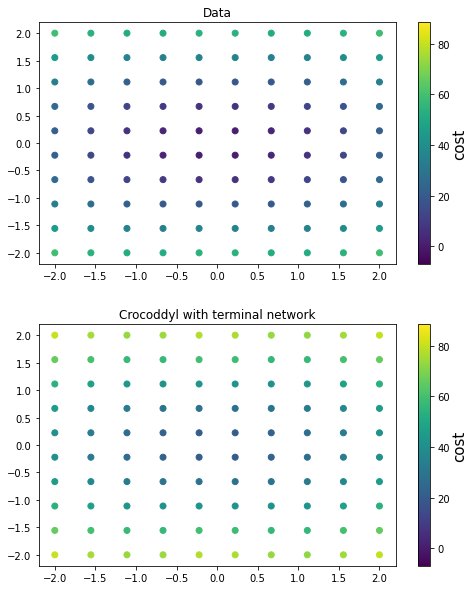

In [29]:
plot(y_t_cost, y_p_cost, name = 'cost')

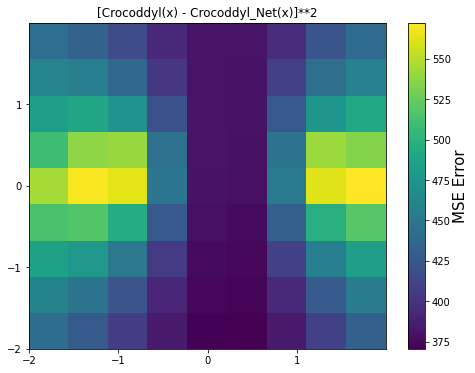

In [30]:
scatter_mse(y_t_cost, y_p_cost)

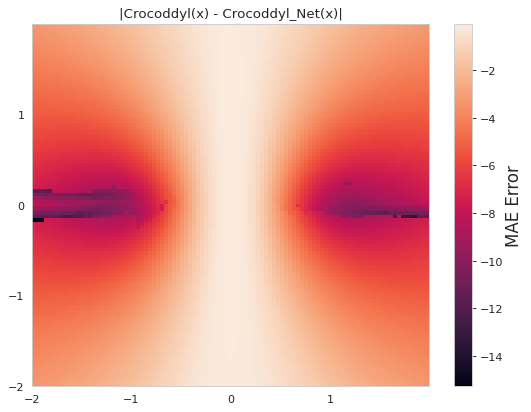

In [140]:
scatter_mae(y_t_cost, y_p_cost)

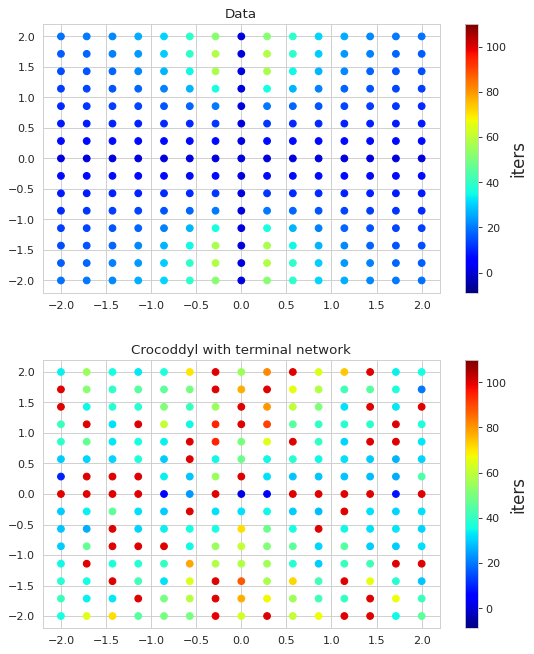

In [126]:
def plot_iters(net):
    
    net.eval()
    N_iterations = []
   
    C_iterations = []
   
    
    xrange = np.linspace(-2.,2.,15)
    xtest = np.array([ [x1,x2, 0.] for x1 in xrange for x2 in xrange ])
    
    for xyz in xtest:
        model = crocoddyl.ActionModelUnicycle()
        T = 30
        model.costWeights = np.matrix([1,1]).T
        modelValueTerminal = UnicycleTerminal(net)
        problem = crocoddyl.ShootingProblem(m2a(xyz).T, [ model ] * T, modelValueTerminal)
        ddp = crocoddyl.SolverDDP(problem)
        ddp.solve()
        N_iterations.append([ddp.iter])
        del model, modelValueTerminal, ddp, problem
       

        model2 = crocoddyl.ActionModelUnicycle()
        model2.costWeights = np.matrix([1,1]).T        
        problem2 = crocoddyl.ShootingProblem(m2a(xyz).T, [ model2 ] * T, model2)
        ddp2 = crocoddyl.SolverDDP(problem2)
        ddp2.solve()
        C_iterations.append([ddp2.iter])
        
        del model2, problem2, ddp2
        
        
    
    y_true = np.array(C_iterations)

    y_pred = np.array(N_iterations)
    
    
    plt.figure(2,figsize=[8,10])
    plt.set_cmap('jet')

    trange = [ min(y_true),max(y_true) ]
    prange = [ min(y_pred),max(y_pred) ]
    vrange = [ min(trange+prange),max(trange+prange)]
    vd  = vrange[1]-vrange[0]
    vrange = [ vrange[0]-vd*.1, vrange[1]+vd*.1 ]
    
    plt.subplot(2,1,1)
    plt.scatter(xtest[:,0],xtest[:,1],c=y_true.flat,vmin=vrange[0],vmax=vrange[1])
    plt.colorbar().set_label('iters',labelpad=2, size=15)
    plt.title('Data')
    plt.savefig("CrocIters.png")
    
    plt.subplot(2,1,2)
    plt.scatter(xtest[:,0],xtest[:,1],c=y_pred.flat,vmin=vrange[0],vmax=vrange[1])
    plt.colorbar().set_label('iters',labelpad=2, size=15)
    plt.title('Crocoddyl with terminal network')
    plt.savefig("CrocNetIters.png")

    plt.subplots_adjust(hspace=0.25)
    
plot_iters(net)

In [133]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns



def plotTrajectories(cost_trajectory, if_crocoddyl:bool = True):
    """
    Data must be in a dictionary -> key : (x,y)
    
    """
    sns.set_style("whitegrid")
    mpl.rcParams['figure.dpi'] = 80
    fig = plt.figure(figsize=(8, 6))
    
    c = cost_trajectory.keys()
    norm = mpl.colors.Normalize(vmin=min(c), vmax=max(c))
    cmap = mpl.cm.ScalarMappable(norm = norm, cmap=mpl.cm.jet)
    cmap.set_array([])


    for key, trajectory in cost_trajectory.items():
        plt.scatter(trajectory[:, 0], trajectory[:, 1], 
                    marker = '',
                    zorder=2, 
                    s=50,
                    linewidths=0.2,
                    alpha=.8, 
                    cmap = cmap )
        plt.plot(trajectory[:, 0], trajectory[:, 1], c=cmap.to_rgba(key))

    plt.xlabel("X Coordinates", fontsize = 20)
    plt.ylabel("Y Coordinates", fontsize = 20)
    plt.colorbar(cmap).set_label("Cost")

    if if_crocoddyl:
        plt.title("Crocoddyl ", fontsize =20)
        #plt.savefig("CrocTraj.png")
    else:
        plt.title(" Crocoddyl + Neural Net ", fontsize =20)
        #plt.savefig("crocNetTraj.png")
    plt.show()

In [134]:

def cost_croc():
    xtest = points(150)
    cost = {}
    for xyz in xtest:
        model = crocoddyl.ActionModelUnicycle()
        T = 30
        model.costWeights = np.matrix([1,1]).T
        problem = crocoddyl.ShootingProblem(m2a(xyz).T, [ model ] * T, model)
        ddp = crocoddyl.SolverDDP(problem)
        ddp.solve()
        xs_ = np.array(ddp.xs)
        xs = xs_[:,0:2]
        cost[ddp.cost] = xs

    return cost

def cost_net(net):
    net.eval()
    xtest = points(100)
    cost = {}
    for xyz in xtest:
        model = crocoddyl.ActionModelUnicycle()
        terminal = UnicycleTerminal(net)
        T = 30
        model.costWeights = np.matrix([1,1]).T
        problem = crocoddyl.ShootingProblem(m2a(xyz).T, [ model ] * T, terminal)
        ddp = crocoddyl.SolverDDP(problem)
        ddp.solve()
        xs_ = np.array(ddp.xs)
        xs = xs_[:,0:2]
        cost[ddp.cost] = xs

    return cost
    
    

In [135]:
c = cost_croc()

In [136]:
n = cost_net(net)

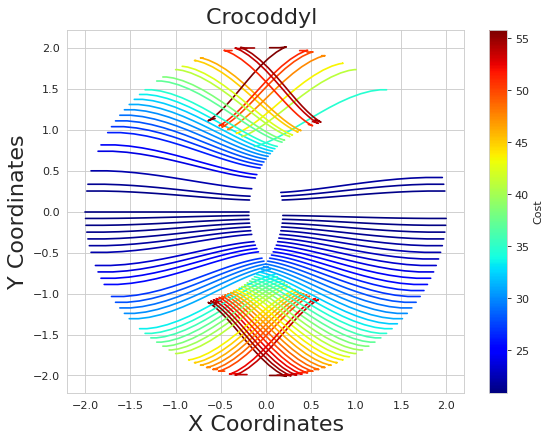

In [137]:
plotTrajectories(c)

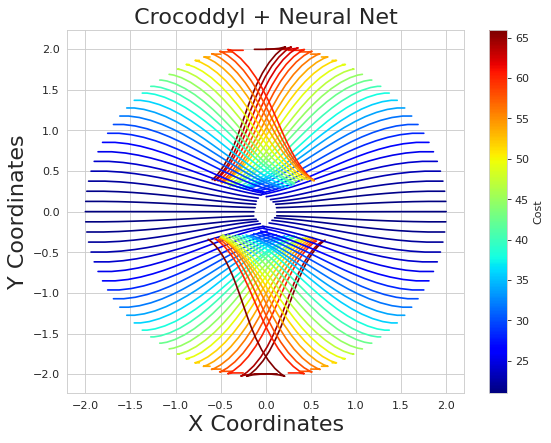

In [138]:
plotTrajectories(n, False)